# Neural Image Generator

Neural Transfer is a popular technique used in computer vision and deep learning to generate images that combine the style of one image with the content of another. This is achieved by training a neural network to extract the style and content information from two input images, and then using that network to generate a new image that combines the two.

The Neural Transfer by PyTorch project is a Python-based implementation of this technique using the PyTorch deep learning framework. It provides a simple and flexible way to perform Neural Transfer on any pair of images, allowing users to experiment with different combinations of styles and content.

The project is built around a pre-trained deep neural network architecture called VGG-19, which is used to extract the feature maps from the input images. These feature maps are then used to calculate the content loss and style loss, which are combined to form the total loss function. The optimization process then aims to minimize this loss function to generate the final output image.

The Neural Transfer by PyTorch project provides a user-friendly interface that allows users to adjust various parameters and settings, such as the learning rate, number of iterations, and style and content weights, to fine-tune the generated images. Additionally, the project includes a set of pre-trained models for different styles, making it easy for users to quickly generate images with a specific style.

## Setup

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
from utils import imshow,gram_matrix,ContentLoss,StyleLoss,Normalization

Now we use `torch.cuda.is_available()` to check if there is a GPU on our device. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

False

We have to transfer the original image into torch tensors with values converted to be between 0 and 1 as our  original PIL images have values between 0 and 255. Also here we resize the image to be small if there is no Gpu assigned.

In [46]:
if torch.cuda.is_available():
    imsize = 512
else:
    imsize = 128
loader = transforms.Compose([
transforms.Resize(imsize), 
transforms.ToTensor()]) 

In [38]:
style_image = (loader(Image.open("data/sunflower.jpg").convert('RGB')).unsqueeze(0)).to(device, torch.float)
content_image = (loader(Image.open("data/cat.jpg").convert('RGB')).unsqueeze(0)).to(device, torch.float)

Here we create a imshow function in `utils.py` to displays an image by reconverting a copy of it to PIL format and displaying the copy using plt.imshow. 

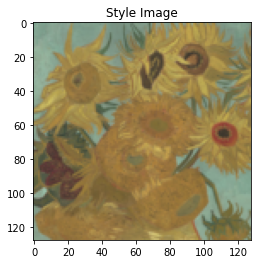

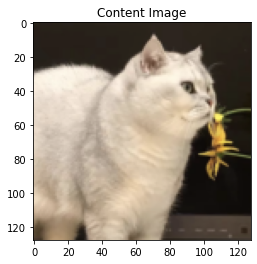

In [39]:
plt.ion()
plt.figure()
imshow(style_image, title='Style Image')
plt.figure()
imshow(content_image, title='Content Image')

## Loss Function

### Content Loss
The content loss measures the difference between the content of the input image and the generated image. It is calculated by comparing the feature maps extracted from a pre-trained deep neural network at a particular layer of the input image and the generated image. The content loss ensures that the generated image maintains the underlying structure and arrangement of the content of the input image.

We add the content loss module after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. In order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.

### Style Loss
The style loss measures the difference between the texture and patterns of the input image and the generated image. It is calculated by comparing the correlation of feature maps between the input image and the generated image at multiple layers of the pre-trained deep neural network. The style loss ensures that the generated image replicates the style of the input image, including its color palette, brushstrokes, and other characteristic features.

During the optimization process, the content loss and style loss are combined to form the total loss function, which is minimized using gradient descent to generate the final output image. The relative weighting of the content loss and style loss in the total loss function can be adjusted to achieve different trade-offs between content preservation and style transfer in the generated image.

## Build the model

As mentioned before, we can use a 19 layer VGG network as our pre-trained neural network here.

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/Users/haoyuechen/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/haoyuechen/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Also, we know that each channel is normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] when training the VGG networks on images. So here we define tensors to normalize the image before sending it into the network.

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

A Sequential module contains an ordered list of child modules. For instance, `vgg19.features` contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # Normalization
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Content Loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Style Loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

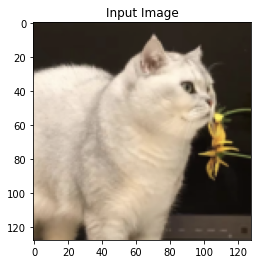

In [36]:
input_image = content_image.clone()
plt.figure()
imshow(input_image, title='Input Image')

We want to train the input image in order to minimise the content and style losses. For this purpose a PyTorch L-BFGS optimizer `optim.LBFGS` is used here to optimize.

In [14]:
def get_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

Now a function that performs the neural transfer can be defined here. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

In [15]:
def style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
 
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)


    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/Users/haoyuechen/Documents/cv_dl/neural_style/utils.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/Users/haoyuechen/Documents/cv_dl/neural_style/utils.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 81.849449 Content Loss: 18.038742

run [100]:
Style Loss : 31.677683 Content Loss: 16.194069

run [150]:
Style Loss : 14.513493 Content Loss: 14.358738

run [200]:
Style Loss : 7.364806 Content Loss: 12.830887

run [250]:
Style Loss : 4.486047 Content Loss: 11.655521

run [300]:
Style Loss : 3.326578 Content Loss: 10.806919



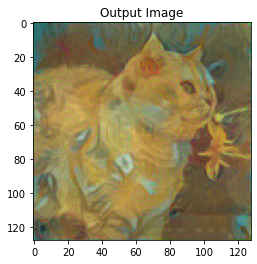

In [40]:
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image, input_image)

Now we can visualize the image to see how well it performs:

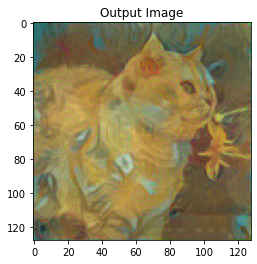

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure()
imshow(output, title='Output Image')
plt.savefig('output.jpg')
#plt.ioff()
plt.show()